In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gym
import gym_cartpole_swingup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import seaborn as sb
import math
from IPython.display import clear_output

In [ ]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common import results_plotter

In [ ]:
lbr = "\n"

ObservationWrapper

In [ ]:
class NoisedObservationWrapper(gym.Wrapper):
    # encapsulate environment with this wrapper and use env just like before:
    # env = NoisedObservationWrapper(gym.make("CartPole-v0"))
    # for PPO2:
    # from stable_baselines.common import make_vec_env
    # env = make_vec_env(NoisedObservationWrapper(gym.make("CartPole-v0")))

    def __init__(self, env, std_dev=0.3, mean=0, angle_min=10, angle_max=20, local_path="false"):
        super().__init__(env)
        self.env = env
        self.std_dev = std_dev
        self.mean = mean
        self.angle_min = np.radians(angle_min)
        self.angle_max = np.radians(angle_max)
        self.local_path = local_path
        
        if(self.local_path != "false"):
            log_file = open(self.local_path, "w")
            log_file.close()

    def step(self, action):
        # angle of pole is limited between radians [-0.418; 0.418]
        # which corresponds to [-24; 24] degrees
        observation, reward, done, info = self.env.step(action)
        
        angle = observation[2]
        
        noisy = (self.angle_min <= angle <= self.angle_max)

        # add noise if angle position is between angle_min and angle_max
        if (noisy):
            observation[2] += np.random.normal(self.mean, self.std_dev)

        if(self.local_path != "false"):
            log_file = open(self.local_path, "a")
            log_file.write(str((observation, reward, done, info, noisy)))
            log_file.write(lbr)
            log_file.close()      
            
        return observation, reward, done, info
    
    def step_noise(self, action):
        # angle of pole is limited between radians [-0.418; 0.418]
        # which corresponds to [-24; 24] degrees
        observation, reward, done, info = self.env.step(action)
        
        angle = observation[2]
        
        noisy = (self.angle_min <= angle <= self.angle_max)

        # add noise if angle position is between angle_min and angle_max
        if (noisy):
            observation[2] += np.random.normal(self.mean, self.std_dev)

        if(self.local_path != "false"):
            log_file = open(self.local_path, "a")
            log_file.write(str((observation, reward, done, info, noisy)))
            log_file.write(lbr)
            log_file.close()      
            
        return observation, reward, done, info, noisy

In [ ]:
pathprefix = "/content/"
log_dir1 = "logs1"
log_dir2 = "logs2"
os.makedirs(log_dir1, exist_ok=True)
os.makedirs(log_dir2, exist_ok=True)

Environments

In [ ]:
env1Test = gym.make('CartPoleSwingUp-v0')
env1Test = Monitor(env1Test, log_dir1) # required for using callback functions during training
env1Test = DummyVecEnv([lambda: env1Test])
env1Test = VecNormalize(env1Test, norm_obs=True, norm_reward=True) # State normalization

In [ ]:
env2Test = NoisedObservationWrapper(gym.make("CartPoleSwingUp-v0"))
env2Test = Monitor(env2Test, log_dir2) # required for using callback functions during training
env2Test = DummyVecEnv([lambda: env2Test])
env2Test = VecNormalize(env2Test, norm_obs=True, norm_reward=True) # State normalization

Experiment settings

In [ ]:
time_steps=30000
num_experiments = 1
sampleCount = 100

Experiments without Uncertainty

In [ ]:
tensorboard_dir1 = "cartpole1"
os.makedirs(tensorboard_dir1, exist_ok=True)
for e in range (1, (num_experiments+1), 1):
    env1Test.reset()
    log_dir = (log_dir1+ str(e))
    os.makedirs(log_dir, exist_ok=True)
    env1 = gym.make('CartPoleSwingUp-v0')
    env1 = Monitor(env1, log_dir) # required for using callback functions during training
    env1 = DummyVecEnv([lambda: env1])
    env1 = VecNormalize(env1, norm_obs=True, norm_reward=True) # State normalization
    model1 = PPO(MlpPolicy, env1, verbose=0)
    
    clear_output(wait=True)
    print("Run " +  str(e))
    

    eval_callback = EvalCallback(env1Test, best_model_save_path=log_dir,
                             log_path=log_dir, eval_freq=1000,
                             deterministic=True, render=False)
    
    
    
    model1.learn(total_timesteps=time_steps, callback=eval_callback)

    env1.close()
    
    

Run 2
Eval num_timesteps=1000, episode_reward=-19.53 +/- 1.37
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=-17.51 +/- 1.21
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=3000, episode_reward=-8.86 +/- 1.08
Episode length: 249.20 +/- 37.67
New best mean reward!
Eval num_timesteps=4000, episode_reward=-11.31 +/- 4.08
Episode length: 292.40 +/- 105.10
Eval num_timesteps=5000, episode_reward=-6.21 +/- 0.57
Episode length: 169.60 +/- 13.69
New best mean reward!
Eval num_timesteps=6000, episode_reward=-6.44 +/- 0.84
Episode length: 182.60 +/- 19.32
Eval num_timesteps=7000, episode_reward=-4.83 +/- 0.49
Episode length: 155.00 +/- 8.07
New best mean reward!
Eval num_timesteps=8000, episode_reward=-5.04 +/- 0.79
Episode length: 160.00 +/- 25.93
Eval num_timesteps=9000, episode_reward=-5.34 +/- 0.70
Episode length: 163.80 +/- 27.69
Eval num_timesteps=10000, episode_reward=-5.18 +/- 0.21
Episode length: 200.20 +/- 75.82
Ev

Experiment Results without Uncertainty

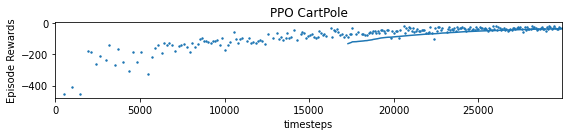

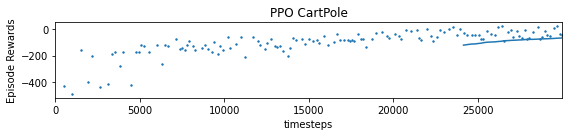

In [ ]:
for e in range (1, (num_experiments+1), 1):

    results_plotter.plot_results([log_dir1+str(e)], time_steps, results_plotter.X_TIMESTEPS, "PPO CartPole")
    plt.savefig("results1-cartpole.png")
    plt.show()


4915575
-20128.994040999998
2238477
-13175.755045999998
2


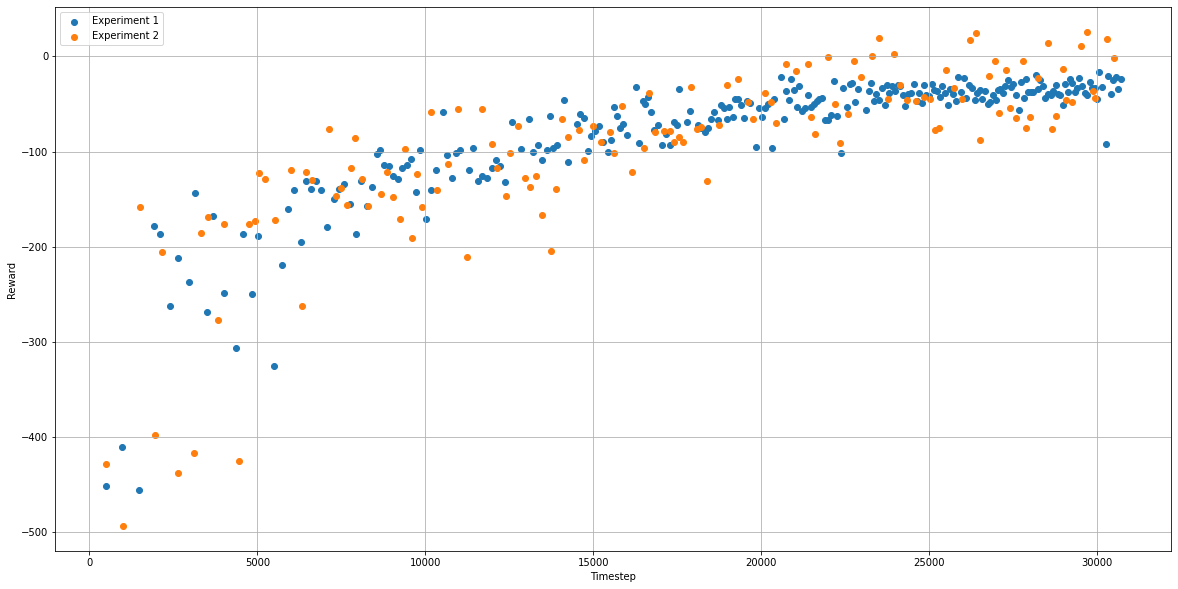

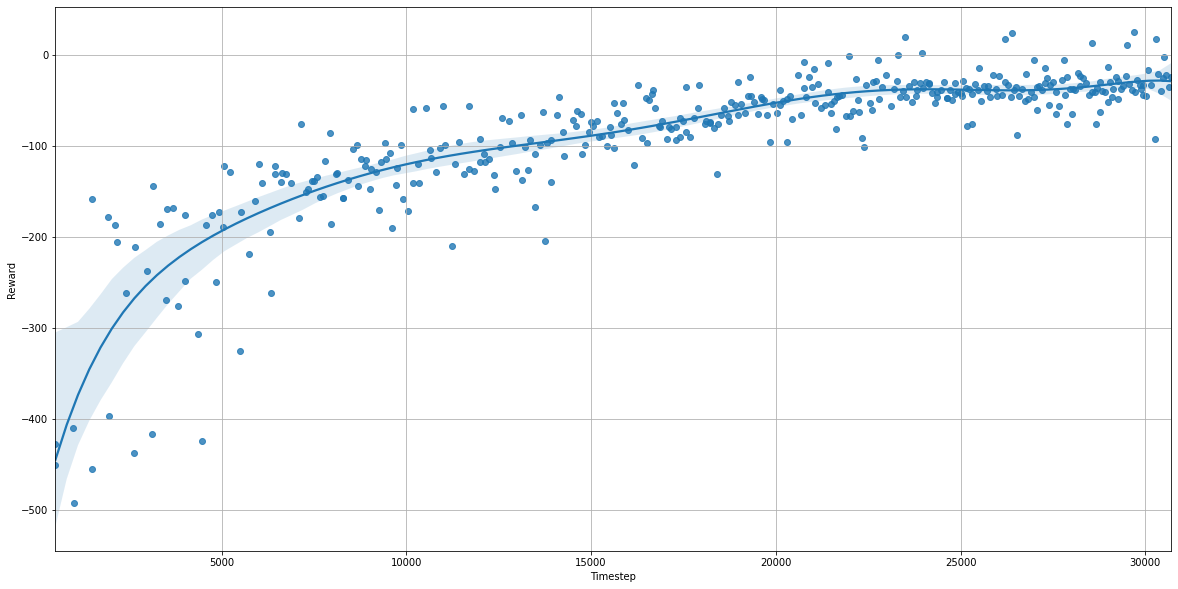

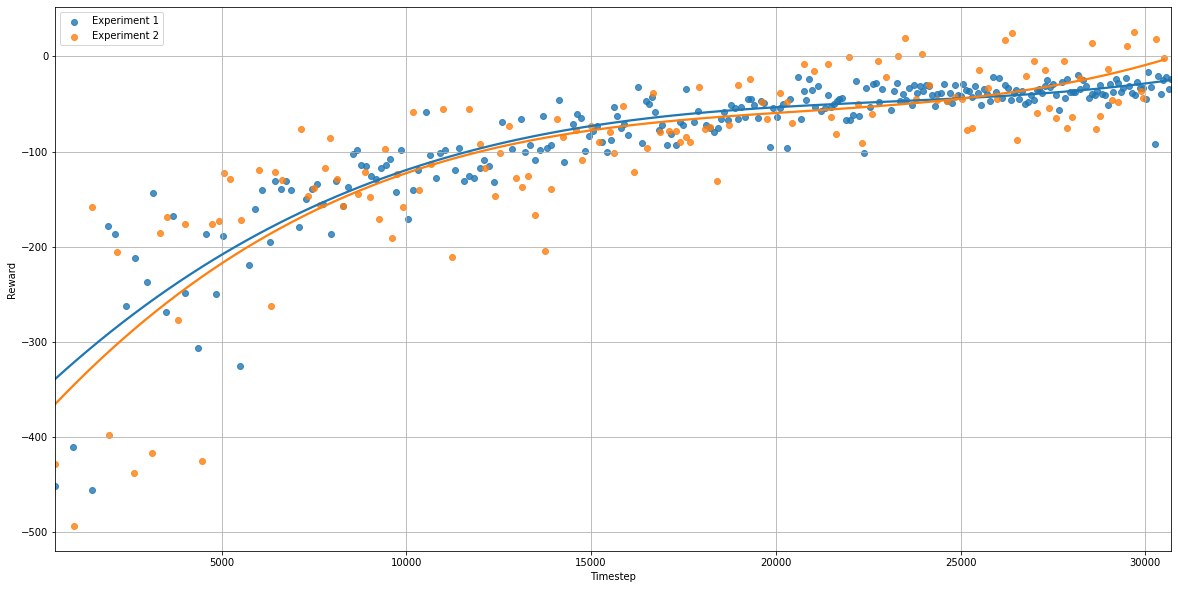

In [ ]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()

store1 = pd.DataFrame()
exps1 = []

maxreward1 = - math.inf
best1 = 0

for e in range (1, (num_experiments+1), 1):
    log_dir = (log_dir1+ str(e))
    x, y = ts2xy(load_results(log_dir), 'timesteps')
    plt.scatter(x=x, y=y, label="Experiment " + str(e))
    #plt.plot(x, y)
    d = {'x': x, 'y': y}
    exp1 = pd.DataFrame(d)
    exps1.append(exp1)
    store1 = store1.append(exp1, ignore_index=True)
    if (np.max(y) > maxreward1):
      best1 = e

print(best1)

plt.legend()
plt.ylabel("Reward")
plt.xlabel("Timestep")

#plt.plot(x_mean, y_mean)
#print(store1)
plt.show()

fig, regplot = plt.subplots(figsize = (20,10))
regplot=sb.regplot(x="x", y="y", data=store1, fit_reg=True, scatter=True, order=8,truncate= True)
regplot.grid()
regplot.set_ylabel("Reward")
regplot.set_xlabel("Timestep")
plt.show()

fig, regplot2 = plt.subplots(figsize = (20,10))
i = 0
for exp1 in exps1:
    i += 1
    sb.regplot(x="x", y="y", data=exp1, fit_reg=True, scatter=True, order=3,truncate= True, ci=None, label="Experiment " + str(i))
regplot2.grid()
regplot2.legend()
regplot2.set_ylabel("Reward")
regplot2.set_xlabel("Timestep")
plt.show()

In [ ]:
import pandas as pd
path = pathprefix + "logs11/monitor.csv"
data = pd.read_csv(str(path), engine='python', index_col=None, skiprows=1)
#print(data)
data.sum(axis=0)


r   -17513.912930
l    30684.000000
t    10539.104578
dtype: float64

Experiments with Uncertainty

In [ ]:
tensorboard_dir2 = "cartpole2"
os.makedirs(tensorboard_dir2, exist_ok=True)
for e in range (1, (num_experiments+1), 1):
    log_dir = (log_dir2 + str(e))
    os.makedirs(log_dir, exist_ok=True)
    env2 = NoisedObservationWrapper(gym.make("CartPoleSwingUp-v0"))
    env2 = Monitor(env2, log_dir) # required for using callback functions during training
    env2 = DummyVecEnv([lambda: env2])
    env2 = VecNormalize(env2, norm_obs=True, norm_reward=True)

    model2 = PPO(MlpPolicy, env2, verbose=0)

    clear_output(wait=True)
    print("Run " +  str(e))

    eval_callback = EvalCallback(env2Test, best_model_save_path=log_dir,
                             log_path=log_dir, eval_freq=1000,
                             deterministic=True, render=False)

    model2.learn(total_timesteps=time_steps, callback=eval_callback)
    
    env2.close()

Run 2
Eval num_timesteps=1000, episode_reward=-19.50 +/- 0.53
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=2000, episode_reward=-20.77 +/- 0.39
Episode length: 500.00 +/- 0.00
Eval num_timesteps=3000, episode_reward=-9.94 +/- 0.83
Episode length: 260.60 +/- 43.98
New best mean reward!
Eval num_timesteps=4000, episode_reward=-8.99 +/- 0.23
Episode length: 219.00 +/- 6.48
New best mean reward!
Eval num_timesteps=5000, episode_reward=-5.49 +/- 0.34
Episode length: 145.60 +/- 11.11
New best mean reward!
Eval num_timesteps=6000, episode_reward=-5.51 +/- 0.43
Episode length: 141.00 +/- 9.82
Eval num_timesteps=7000, episode_reward=-4.30 +/- 0.16
Episode length: 117.00 +/- 4.90
New best mean reward!
Eval num_timesteps=8000, episode_reward=-4.03 +/- 0.46
Episode length: 115.20 +/- 4.35
New best mean reward!
Eval num_timesteps=9000, episode_reward=-3.38 +/- 0.28
Episode length: 103.00 +/- 5.55
New best mean reward!
Eval num_timesteps=10000, episode_reward=-3.36 +/- 0.

Experiment Results with Uncertainty 

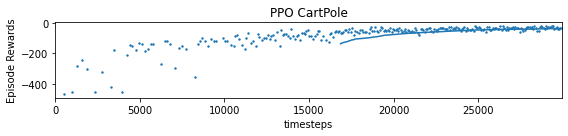

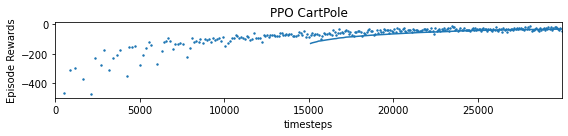

In [ ]:
for e in range (1, (num_experiments+1), 1):

    results_plotter.plot_results([log_dir2+str(e)], time_steps, results_plotter.X_TIMESTEPS, "PPO CartPole")
    plt.savefig("results2-cartpole-" + str(e) + ".png")
    plt.show()

2


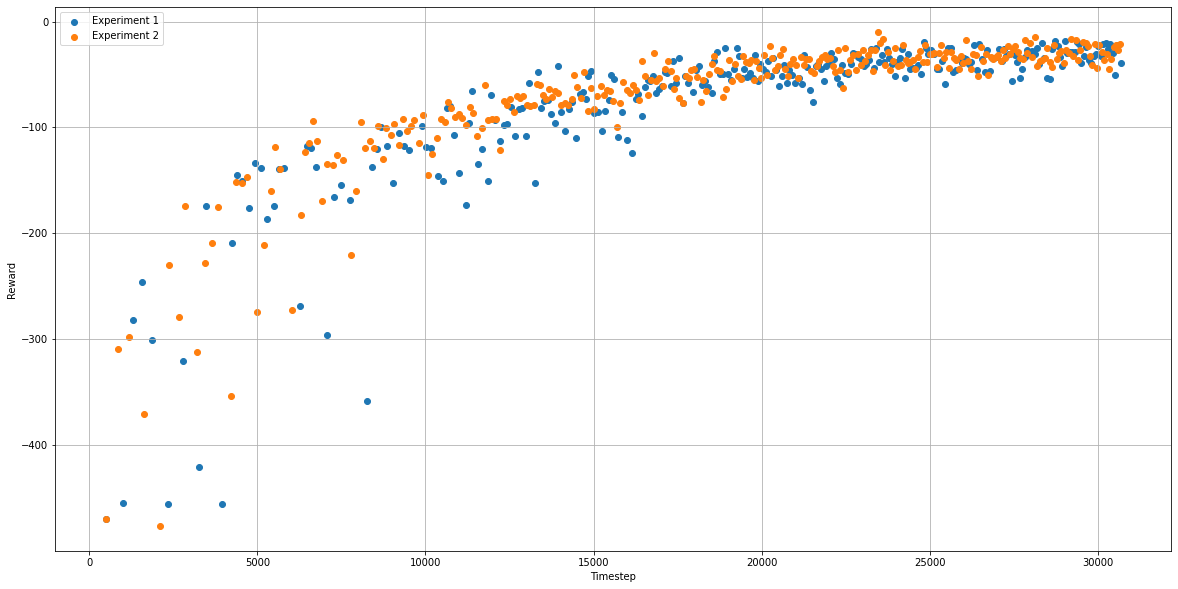

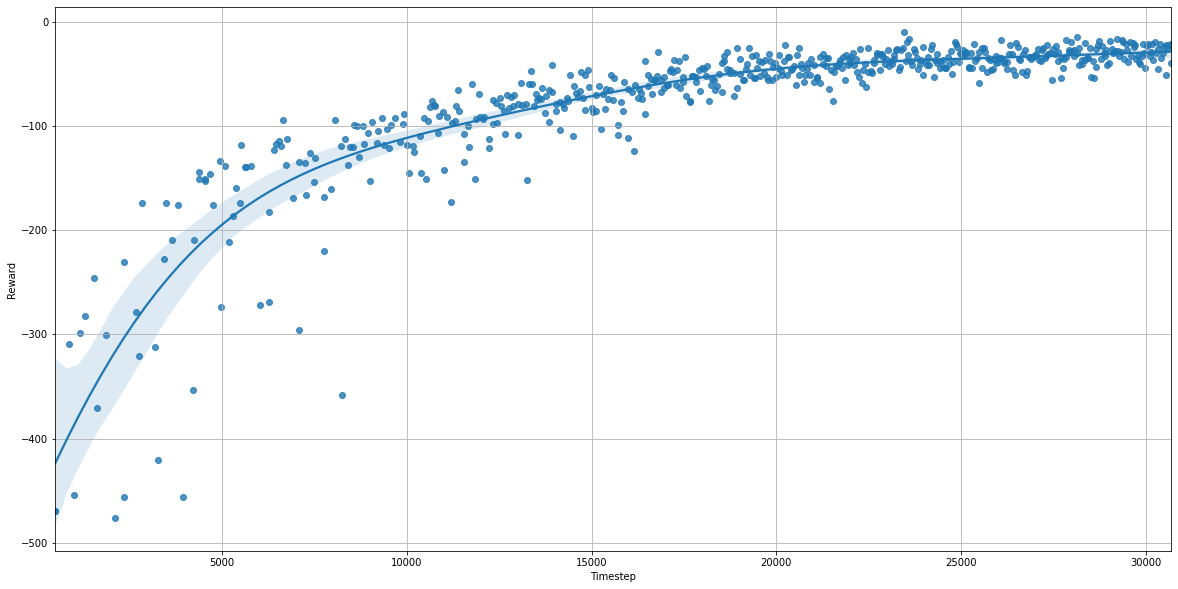

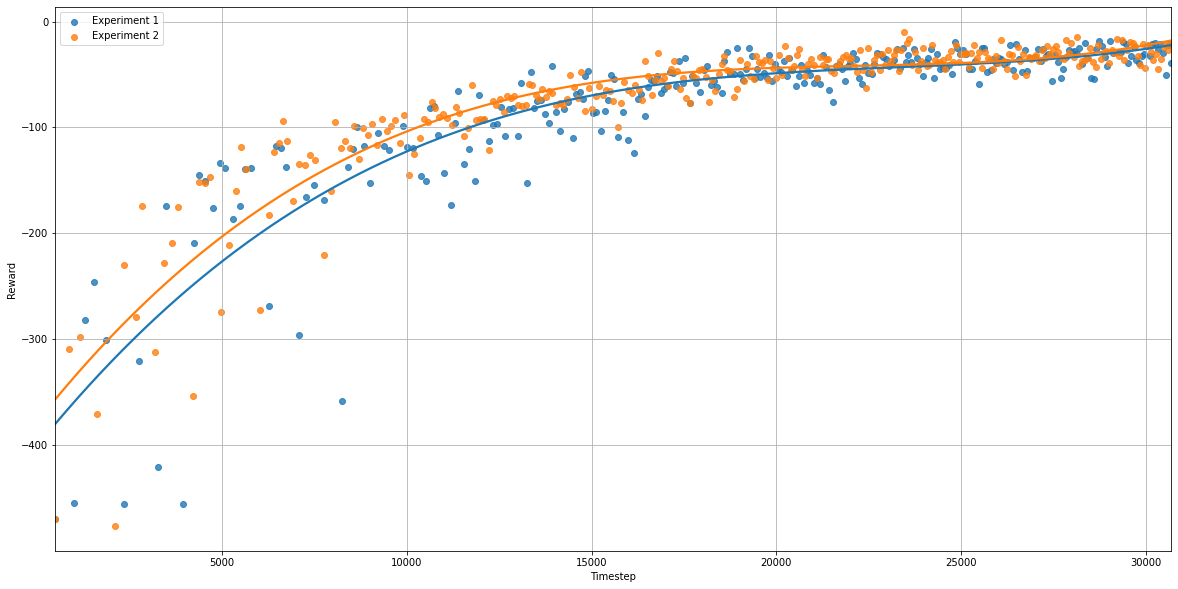

In [ ]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()

maxreward2 = -math.inf
best2 = 0

store2 = pd.DataFrame()
exps2 = []
for e in range (1, (num_experiments+1), 1):
    log_dir = (log_dir2+ str(e))
    x, y = ts2xy(load_results(log_dir), 'timesteps')
    plt.scatter(x=x, y=y, label = "Experiment " + str(e))
    #plt.plot(x, y)
    d = {'x': x, 'y': y}
    exp2 = pd.DataFrame(d)
    exps2.append(exp2)
    store2 = store2.append(exp2, ignore_index=True)
    if (np.max(y) > maxreward2):
      best2 = e

print(best2)

plt.legend()
plt.ylabel("Reward")
plt.xlabel("Timestep")
#plt.plot(x_mean, y_mean)
#print(store)
plt.show()

fig, regplot = plt.subplots(figsize = (20,10))
fig.clf()
regplot=sb.regplot(x="x", y="y", data=store2, fit_reg=True, scatter=True, order=8,truncate= True)
regplot.grid()
regplot.set_ylabel("Reward")
regplot.set_xlabel("Timestep")
plt.show()

fig, regplot2 = plt.subplots(figsize = (20,10))
i = 0
for exp2 in exps2:
    i += 1
    sb.regplot(x="x", y="y", data=exp2, fit_reg=True, scatter=True, order=3,truncate= True, ci=None, label = "Experiment " + str(i))
regplot2.grid()
regplot2.legend()
regplot2.set_ylabel("Reward")
regplot2.set_xlabel("Timestep")
plt.show()



Evaluation of best model



In [ ]:
model = PPO.load("%s/best_model.zip" % (pathprefix + log_dir1+str(best1)))
env = NoisedObservationWrapper(gym.make("CartPoleSwingUp-v0"), local_path="test.txt")
env = Monitor(env, log_dir2) # required for using callback functions during training

env.training=False

expCounter1 = []

exp = 1

while exp <= sampleCount:
    state = env.reset()
    done=False
    cumReward = 0
    steps=0
    noise = 0
    neg = 0
    pos = 0
    while not done: 
        steps += 1
        action, _states = model.predict(state)
        state, reward, done, _, noisy = env.step_noise(action)
        cumReward += reward

        if (action[0]> 0):
            pos += 1
        elif (action[0]< 0):
            neg += 1

        if noisy:
            noise += 1

    env.close()

    if neg > 0:
      negReward = cumReward / neg
      negNoise = noise / neg
    else:
      negReward = 0
      negNoise = 0

    if pos > 0:
      posReward = cumReward / pos
      posNoise = noise / pos
    else:
      posReward = 0
      posNoise = 0
    
    expCounter1.append([steps, cumReward, noise, neg, pos, negReward, posReward, negNoise, posNoise])
    
    clear_output(wait=True)
    print("Experiment " +  str(exp) + " Reward: " + str(cumReward) + " Steps: " + str(neg) + "/" + str(pos) + " Noise: " + str(noise))
    exp+= 1

results1 = np.mat(expCounter1)
#print(results)

stepCounter1 = np.array(results1[:,0])
rewardCounter1 = np.array(results1[:,1])
noiseCounter1 = np.array(results1[:,2])
negCounter1 = np.array(results1[:,3])
posCounter1 = np.array(results1[:,4])
avgNoise1 = np.divide(noiseCounter1,stepCounter1)

negRewardCounter1 = np.array(results1[:,5])
posRewardCounter1 = np.array(results1[:,6])
negNoiseCounter1 = np.array(results1[:,7])
posNoiseCounter1 = np.array(results1[:,8])
stepratio1= np.divide(negCounter1,stepCounter1)
#print(stepCounter)
#print(noiseCounter)
#print(avgNoise)
clear_output(wait=True)
print ("Average Reward: %.3f" % (np.mean(rewardCounter1[:][1])))
print ("Average Step Count: %.3f" % (np.mean(expCounter1[:][1])))
print ("Average Noise: %.3f" % (np.mean(noiseCounter1)))
print ("Average Noise per Length: %.3f" % (np.mean(np.divide(noiseCounter1,stepCounter1))))
print("Steps: " + str(np.sum(negCounter1)) + "/" + str(np.sum(posCounter1)) )
print("Steps Ratio (Neg): " + str(np.mean(np.divide(negCounter1,stepCounter1))))
print("Steps Ratio (Pos): " + str(np.mean(np.divide(posCounter1,stepCounter1))))
print("Average Reward per Negative: " + str(np.mean(negRewardCounter1)))
print("Average Reward per Positive: " + str(np.mean(posRewardCounter1)))
print("Average Noise per Negative: " + str(np.mean(negNoiseCounter1)))
print("Average Noise per Positive: " + str(np.mean(posNoiseCounter1)))

Average Reward: -69.813
Average Step Count: 14.572
Average Noise: 2.244
Average Noise per Length: 0.019
Steps: 36315.0/67849.0
Steps Ratio (Neg): 0.32087526212893647
Steps Ratio (Pos): 0.6791247378710636
Average Reward per Negative: -2.0072258062764265
Average Reward per Positive: -0.7035203150318383
Average Noise per Negative: 0.06507265718023908
Average Noise per Positive: 0.034862449516383454


In [ ]:
model = PPO.load("%s/best_model" % (pathprefix + log_dir2 + str(best2)))
env = NoisedObservationWrapper(gym.make("CartPoleSwingUp-v0"), local_path="test.txt")
env = Monitor(env, log_dir2) # required for using callback functions during training

env.training=False

expCounter2 = []

exp = 1
while exp <= sampleCount:
    state = env.reset()
    done=False
    cumReward = 0
    steps=0
    noise = 0
    neg = 0
    pos = 0

    while not done: 
        steps += 1
        action, _states = model.predict(state)
        state, reward, done, _, noisy = env.step_noise(action)
        cumReward += reward
        
        if (action[0]> 0):
            pos += 1
        elif (action[0]< 0):
            neg += 1

        if noisy:
            noise += 1

    env.close()
    
    if neg > 0:
      negReward = cumReward / neg
      negNoise = noise / neg
    else:
      negReward = 0
      negNoise = 0

    if pos > 0:
      posReward = cumReward / pos
      posNoise = noise / pos
    else:
      posReward = 0
      posNoise = 0
    
    expCounter2.append([steps, cumReward, noise, neg, pos, negReward, posReward, negNoise, posNoise])
    
    clear_output(wait=True)
    print("Experiment " +  str(exp) + " Reward: " + str(cumReward) + " Steps: " + str(neg) + "/" + str(pos) + " Noise: " + str(noise))
    exp+= 1

results2 = np.mat(expCounter2)
#print(results)

stepCounter2 = np.array(results2[:,0])
rewardCounter2 = np.array(results2[:,1])
noiseCounter2 = np.array(results2[:,2])
negCounter2 = np.array(results2[:,3])
posCounter2 = np.array(results2[:,4])
avgNoise2 = np.divide(noiseCounter2,stepCounter2)

negRewardCounter2 = np.array(results2[:,5])
posRewardCounter2 = np.array(results2[:,6])
negNoiseCounter2 = np.array(results2[:,7])
posNoiseCounter2 = np.array(results2[:,8])
stepratio2= np.divide(negCounter2,stepCounter2)
#print(stepCounter)
#print(noiseCounter)
#print(avgNoise)
clear_output(wait=True)
print ("Average Reward: %.3f" % (np.mean(rewardCounter2[:][1])))
print ("Average Step Count: %.3f" % (np.mean(expCounter2[:][2])))
print ("Average Noise: %.3f" % (np.mean(noiseCounter2)))
print ("Average Noise per Length: %.3f" % (np.mean(np.divide(noiseCounter2,stepCounter2))))
print("Steps: " + str(np.sum(negCounter2)) + "/" + str(np.sum(posCounter2)) )
print("Steps Ratio (Neg): " + str(np.mean(np.divide(negCounter2,stepCounter2))))
print("Steps Ratio (Pos): " + str(np.mean(np.divide(posCounter2,stepCounter2))))
print("Average Reward per Negative: " + str(np.mean(negRewardCounter2)))
print("Average Reward per Positive: " + str(np.mean(posRewardCounter2)))
print("Average Noise per Negative: " + str(np.mean(negNoiseCounter2)))
print("Average Noise per Positive: " + str(np.mean(posNoiseCounter2)))

Average Reward: -29.802
Average Step Count: 8.994
Average Noise: 2.243
Average Noise per Length: 0.030
Steps: 3346.0/71023.0
Steps Ratio (Neg): 0.04501072352824346
Steps Ratio (Pos): 0.9549892764717565
Average Reward per Negative: -13.35866912684724
Average Reward per Positive: -0.5000473123000837
Average Noise per Negative: 0.8066047619047619
Average Noise per Positive: 0.03196368789331207


Experiment Length

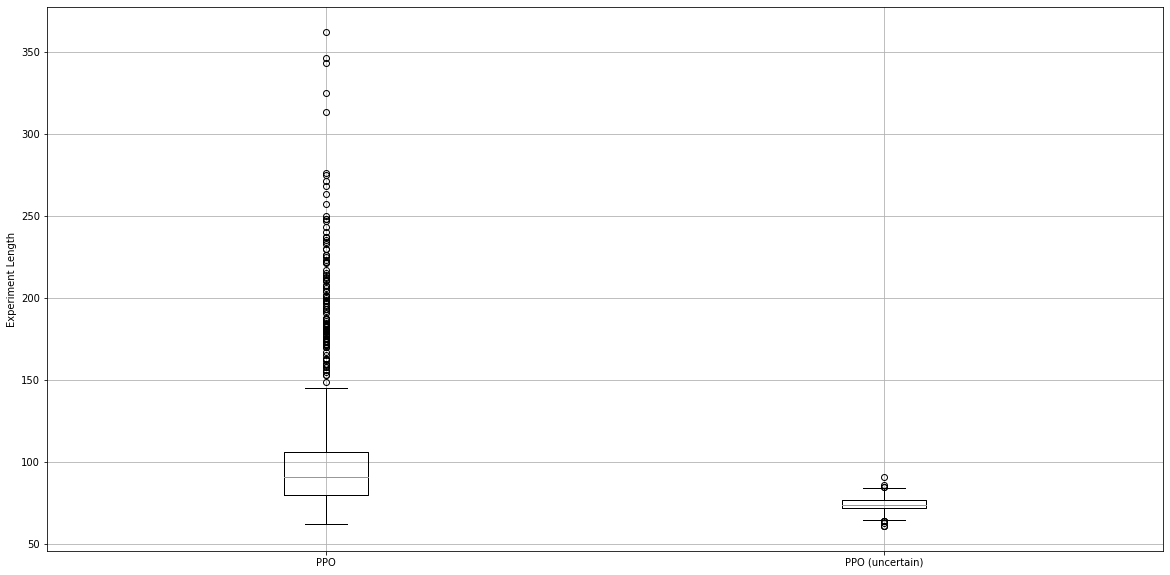

In [ ]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()

boxplot_data = {'PPO':np.reshape(stepCounter1,newshape=-1), 'PPO (uncertain)':np.reshape(stepCounter2,newshape=-1)}

plt.boxplot(boxplot_data.values(), labels = boxplot_data.keys())

plt.ylabel("Experiment Length")

plt.show()

Noise per Experiment Length

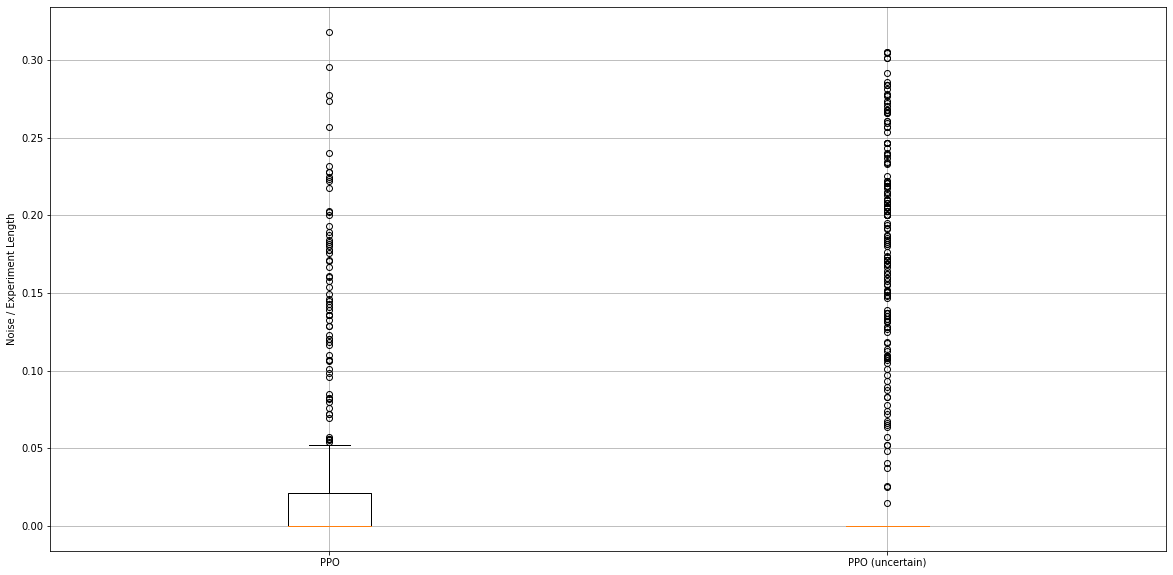

In [ ]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()


boxplot_data = {'PPO':np.reshape(np.divide(noiseCounter1,stepCounter1),newshape=-1), 'PPO (uncertain)':np.reshape(np.divide(noiseCounter2,stepCounter2),newshape=-1)}

plt.boxplot(boxplot_data.values(), labels = boxplot_data.keys())

plt.ylabel("Noise / Experiment Length")

plt.show()

Noise per Length

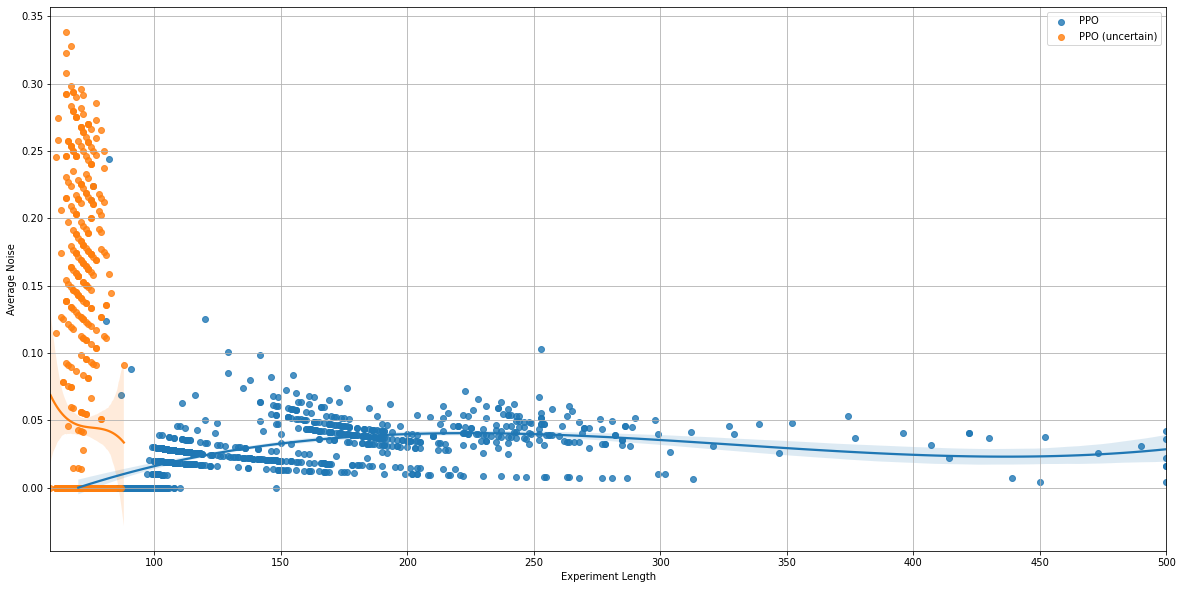

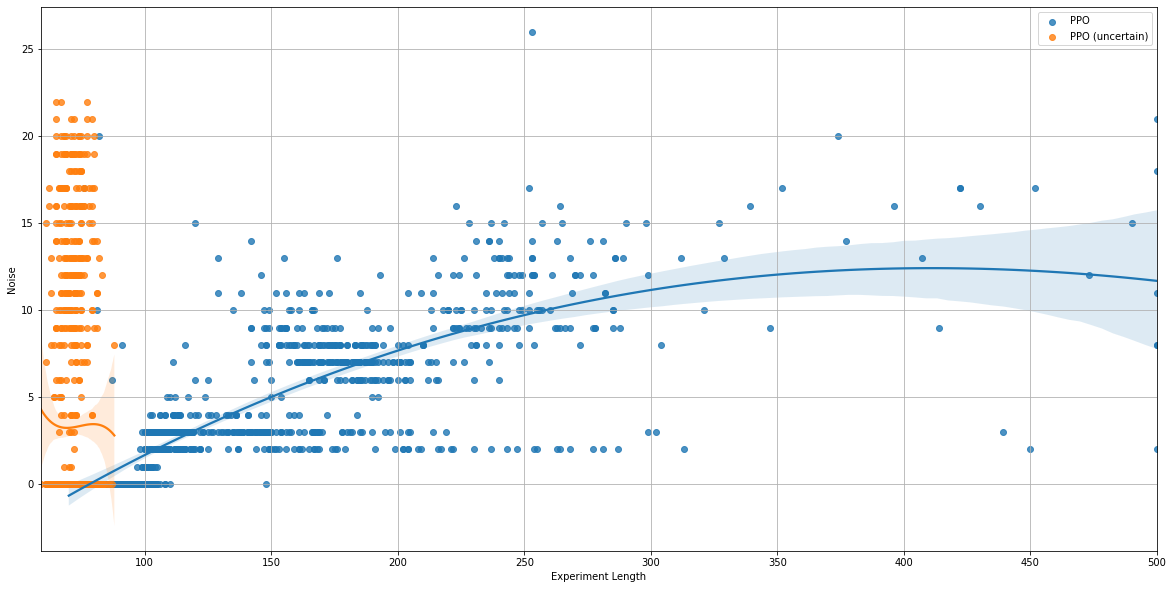

In [ ]:
fig, regplot = plt.subplots(figsize = (20,10))
sb.regplot(x=np.reshape(stepCounter1,-1), y=np.reshape(avgNoise1,-1), fit_reg=True, scatter=True, order=3,truncate= True, label="PPO")
sb.regplot(x=np.reshape(stepCounter2,-1), y=np.reshape(avgNoise2,-1), fit_reg=True, scatter=True, order=3,truncate= True, label="PPO (uncertain)")
regplot.legend()
regplot.set_ylabel("Average Noise")
regplot.set_xlabel("Experiment Length")
regplot.grid()
plt.show()

fig, regplot = plt.subplots(figsize = (20,10))
sb.regplot(x=np.reshape(stepCounter1,-1), y=np.reshape(noiseCounter1,-1), fit_reg=True, scatter=True, order=3,truncate= True, label="PPO")
sb.regplot(x=np.reshape(stepCounter2,-1), y=np.reshape(noiseCounter2,-1), fit_reg=True, scatter=True, order=3,truncate= True, label="PPO (uncertain)")
#regplot.set_xlim(0, 1) # limit y axis
regplot.set_ylabel("Noise")
regplot.set_xlabel("Experiment Length")
regplot.legend()
regplot.grid()
plt.show()

Noise per Reward

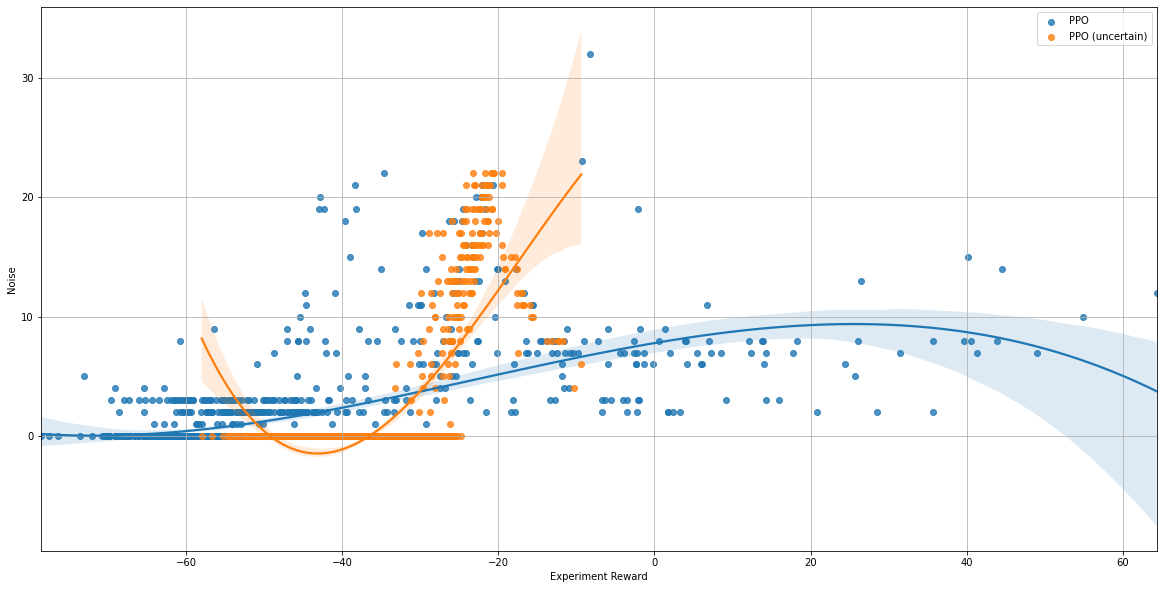

In [56]:
fig, regplot = plt.subplots(figsize = (20,10))
sb.regplot(x=np.reshape(rewardCounter1,-1), y=np.reshape(noiseCounter1,-1), fit_reg=True, scatter=True, order=3,truncate= True, label="PPO")
sb.regplot(x=np.reshape(rewardCounter2,-1), y=np.reshape(noiseCounter2,-1), fit_reg=True, scatter=True, order=3,truncate= True, label="PPO (uncertain)")
#regplot.set_xlim(0, 1) # limit y axis
regplot.set_ylabel("Noise")
regplot.set_xlabel("Experiment Reward")
regplot.legend()
regplot.grid()
plt.show()

Reward per Experiment Length

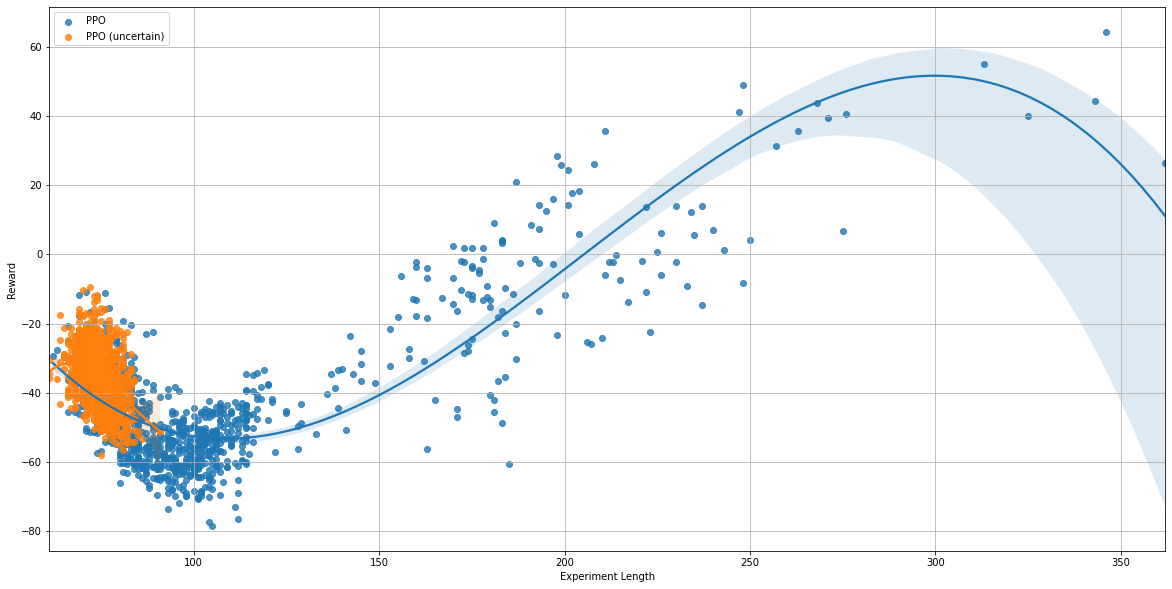

In [58]:
fig, regplot = plt.subplots(figsize = (20,10))
sb.regplot(x=np.reshape(stepCounter1,-1), y=np.reshape(rewardCounter1,-1), fit_reg=True, scatter=True, order=3,truncate= True, label="PPO")
sb.regplot(x=np.reshape(stepCounter2,-1), y=np.reshape(rewardCounter2,-1), fit_reg=True, scatter=True, order=3,truncate= True, label="PPO (uncertain)")
#regplot.set_xlim(0, 1) # limit y axis
regplot.set_ylabel("Reward")
regplot.set_xlabel("Experiment Length")
regplot.legend()
regplot.grid()
plt.show()

Direction

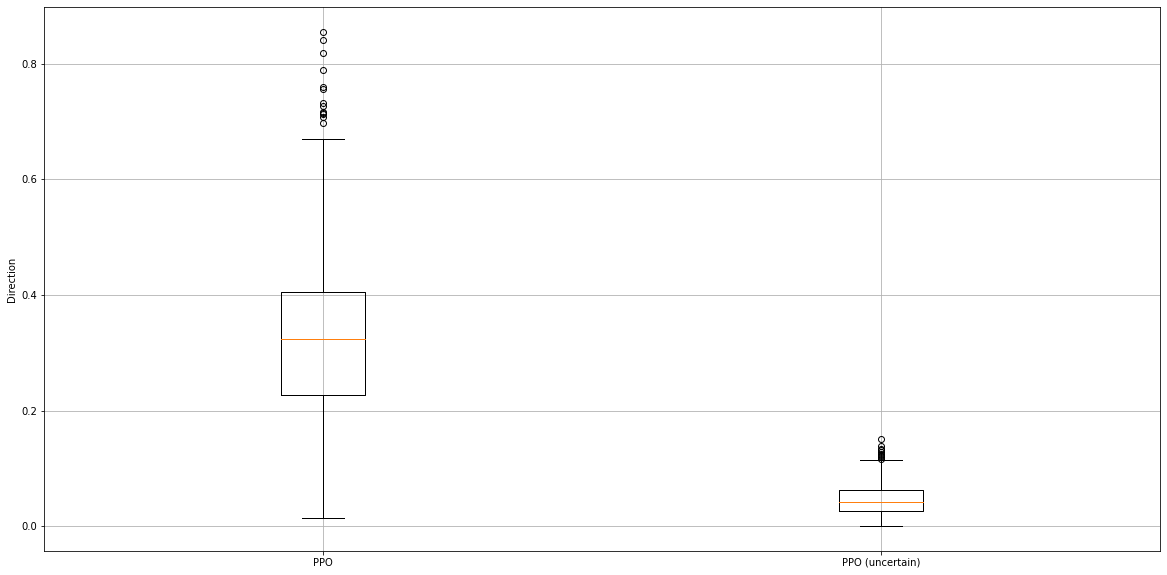

In [63]:
plt.figure(figsize=(20,10))
plt.clf()
plt.grid()


boxplot_data = {'PPO':np.reshape(stepratio1,newshape=-1), 'PPO (uncertain)':np.reshape(stepratio2,newshape=-1)}

plt.boxplot(boxplot_data.values(), labels = boxplot_data.keys())

plt.ylabel("Direction")

plt.show()

Experiment Length per Direction

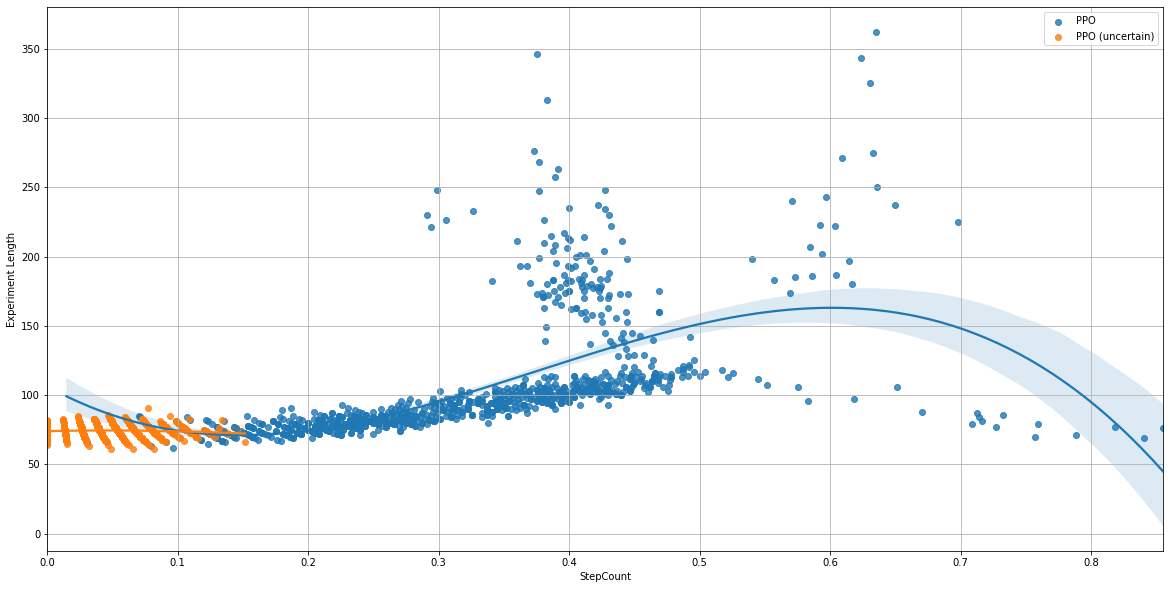

In [61]:
fig, regplot = plt.subplots(figsize = (20,10))
sb.regplot(x=np.reshape(stepratio1,-1), y=np.reshape(stepCounter1,-1), fit_reg=True, scatter=True, order=3,truncate= True, label="PPO")
sb.regplot(x=np.reshape(stepratio2,-1), y=np.reshape(stepCounter2,-1), fit_reg=True, scatter=True, order=3,truncate= True, label="PPO (uncertain)")
#regplot.set_xlim(0, 1) # limit y axis
regplot.set_ylabel("Experiment Length")
regplot.set_xlabel("Direction")
regplot.legend()
regplot.grid()
plt.show()

Reward per Direction

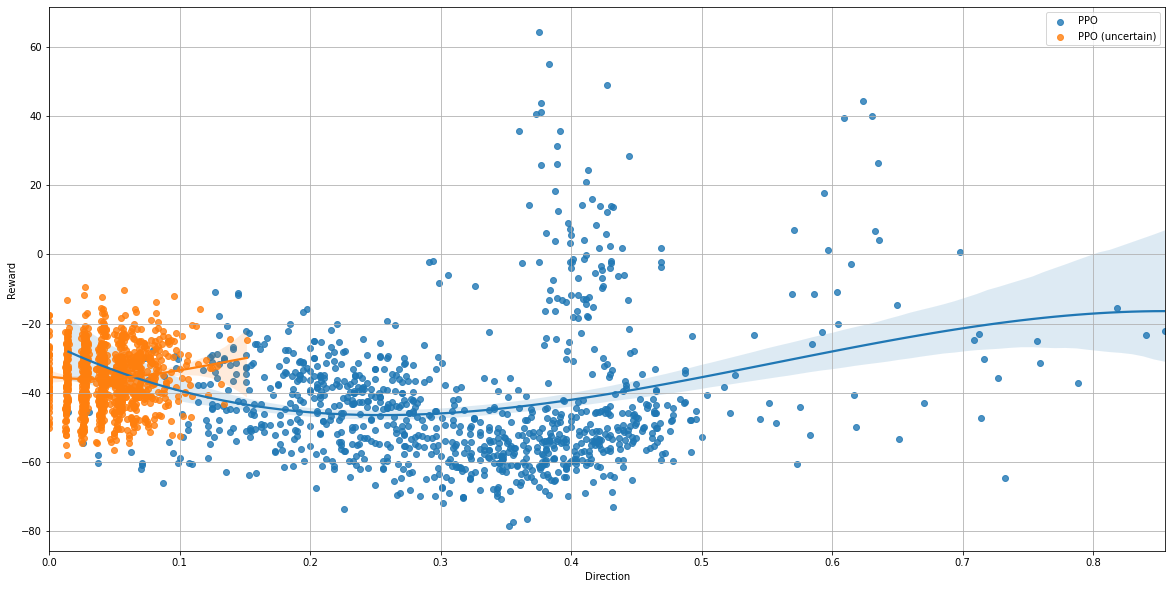

In [64]:
fig, regplot = plt.subplots(figsize = (20,10))
sb.regplot(x=np.reshape(stepratio1,-1), y=np.reshape(rewardCounter1,-1), fit_reg=True, scatter=True, order=3,truncate= True, label="PPO")
sb.regplot(x=np.reshape(stepratio2,-1), y=np.reshape(rewardCounter2,-1), fit_reg=True, scatter=True, order=3,truncate= True, label="PPO (uncertain)")
#regplot.set_xlim(0, 1) # limit y axis
regplot.set_ylabel("Reward")
regplot.set_xlabel("Direction")
regplot.legend()
regplot.grid()
plt.show()

Noise per Direction

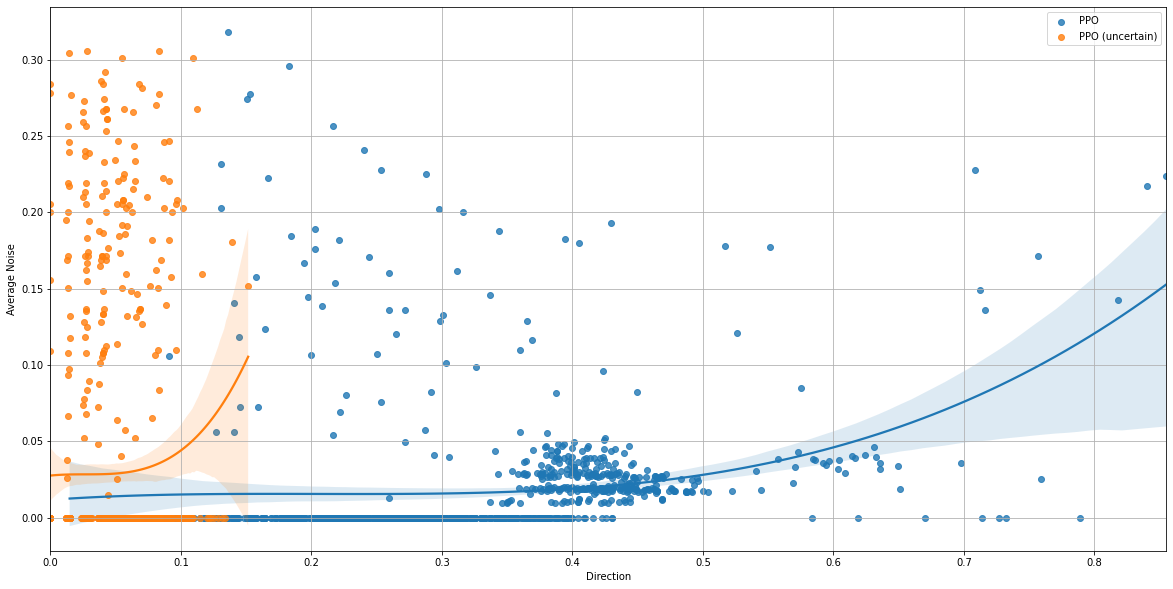

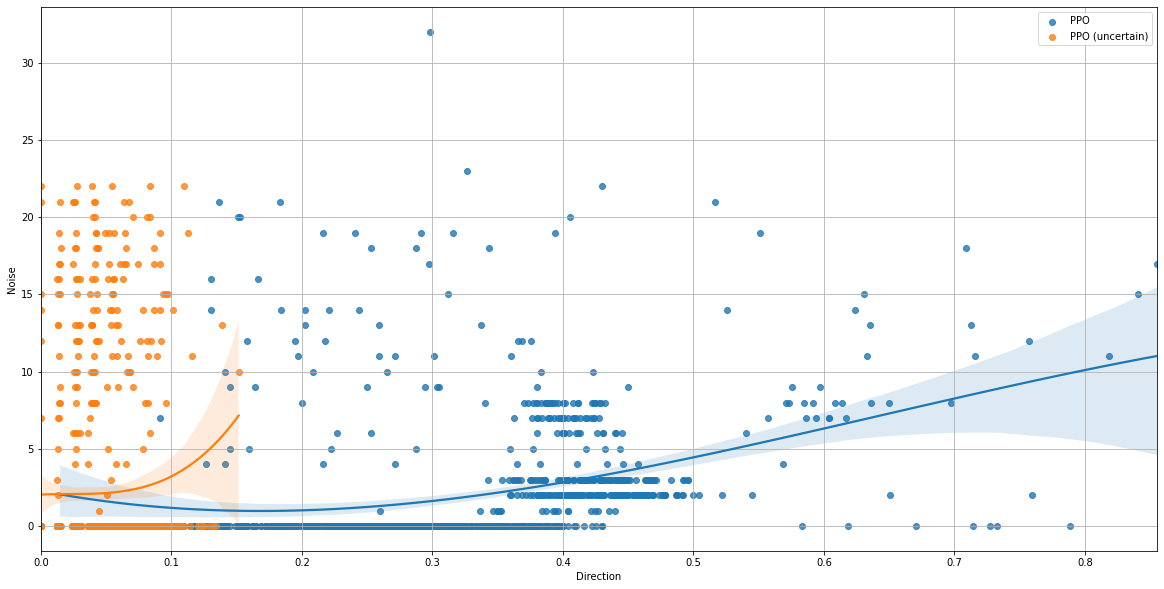

In [65]:
fig, regplot = plt.subplots(figsize = (20,10))
sb.regplot(x=np.reshape(stepratio1,-1), y=np.reshape(avgNoise1,-1), fit_reg=True, scatter=True, order=3,truncate= True, label="PPO")
sb.regplot(x=np.reshape(stepratio2,-1), y=np.reshape(avgNoise2,-1), fit_reg=True, scatter=True, order=3,truncate= True, label="PPO (uncertain)")
regplot.legend()
regplot.set_ylabel("Average Noise")
regplot.set_xlabel("Direction")
regplot.grid()
plt.show()

fig, regplot = plt.subplots(figsize = (20,10))
sb.regplot(x=np.reshape(stepratio1,-1), y=np.reshape(noiseCounter1,-1), fit_reg=True, scatter=True, order=3,truncate= True, label="PPO")
sb.regplot(x=np.reshape(stepratio2,-1), y=np.reshape(noiseCounter2,-1), fit_reg=True, scatter=True, order=3,truncate= True, label="PPO (uncertain)")
#regplot.set_xlim(0, 1) # limit y axis
regplot.set_ylabel("Noise")
regplot.set_xlabel("Direction")
regplot.legend()
regplot.grid()
plt.show()